Showing Stan samples correctly for the simple "bunch of normals being led around" problem.

In [1]:
# set up Python
import json
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2
from cmdstanpy import CmdStanModel
import plotnine
from plotnine import *

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
N = 1000

In [3]:
data_file_name = "stan_test_data.json"
src_file_name = "stan_test_src.stan"

In [4]:
stan_src = """
data {
  int<lower=1> N;
}
parameters {
  real c;
  vector[N] x;
}
model {
  c ~ normal(0, 1);
  x ~ normal(c, 1);
}
"""

In [5]:

data_str = f"""
{{
  "N": {N}
}}
"""

In [6]:

with open(data_file_name, "w", encoding="utf8") as file:
    file.write(data_str)
with open(src_file_name, "w", encoding="utf8") as file:
    file.write(stan_src)
# instantiate the model object
model = CmdStanModel(stan_file=src_file_name)
# fit the model and draw observations
# https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.sample
# https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.optimize
fit = model.sample(
    data=data_file_name,
    show_progress=False,
    show_console=False,
)
# get the samples
res = fit.draws_pd()

In [7]:
res

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,c,x[1],x[2],...,x[991],x[992],x[993],x[994],x[995],x[996],x[997],x[998],x[999],x[1000]
0,-510.049,0.991346,0.030528,7.0,127.0,0.0,1012.720,1.689860,0.390167,2.037180,...,1.672930,1.700610,0.858141,3.272410,2.392000,0.550654,3.503100,0.042170,1.592880,2.248510
1,-493.726,0.737389,0.030528,7.0,127.0,0.0,1007.930,1.662130,2.727880,-0.031199,...,1.647400,1.926470,2.220600,0.556554,0.271787,4.039690,0.318867,1.942550,2.986350,1.131360
2,-549.770,0.967687,0.030528,7.0,127.0,0.0,1038.460,1.681770,0.609981,3.193970,...,2.020980,1.533330,1.535410,3.539470,3.209050,-0.610171,3.337470,4.022920,-0.959126,1.934920
3,-491.817,0.731935,0.030528,7.0,127.0,0.0,1018.610,1.557910,1.522040,0.193501,...,1.638500,0.380142,2.629640,1.279870,1.156810,3.336530,0.934073,0.609810,2.446630,1.755480
4,-499.006,0.997672,0.030528,7.0,127.0,0.0,996.169,1.550590,0.675684,2.763360,...,1.293160,2.064850,1.304070,0.424592,1.218900,3.038380,0.595935,2.016410,1.827490,1.766270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-496.633,0.998509,0.033783,7.0,127.0,0.0,1000.460,-0.084077,-0.738411,1.358870,...,0.492672,0.881285,-0.971623,-0.908495,1.944580,0.097450,0.516917,0.076660,1.030040,-1.937330
3996,-506.632,0.844448,0.033783,7.0,127.0,0.0,1042.640,0.159394,-0.673169,0.534166,...,1.508610,0.423199,0.977884,0.199324,2.198830,-2.631660,1.183760,0.624837,0.603649,-0.657369
3997,-498.375,0.993672,0.033783,7.0,127.0,0.0,1006.010,0.457240,0.204649,0.344018,...,2.514690,2.193060,-1.256320,0.814634,1.414920,2.369690,2.140290,0.970111,0.241526,0.229995
3998,-488.702,0.999115,0.033783,7.0,127.0,0.0,1007.420,0.557070,-0.068082,1.309970,...,-0.906960,-0.682860,0.682831,0.404069,-0.043996,-1.397870,-1.197460,1.655740,-0.473820,-1.723010


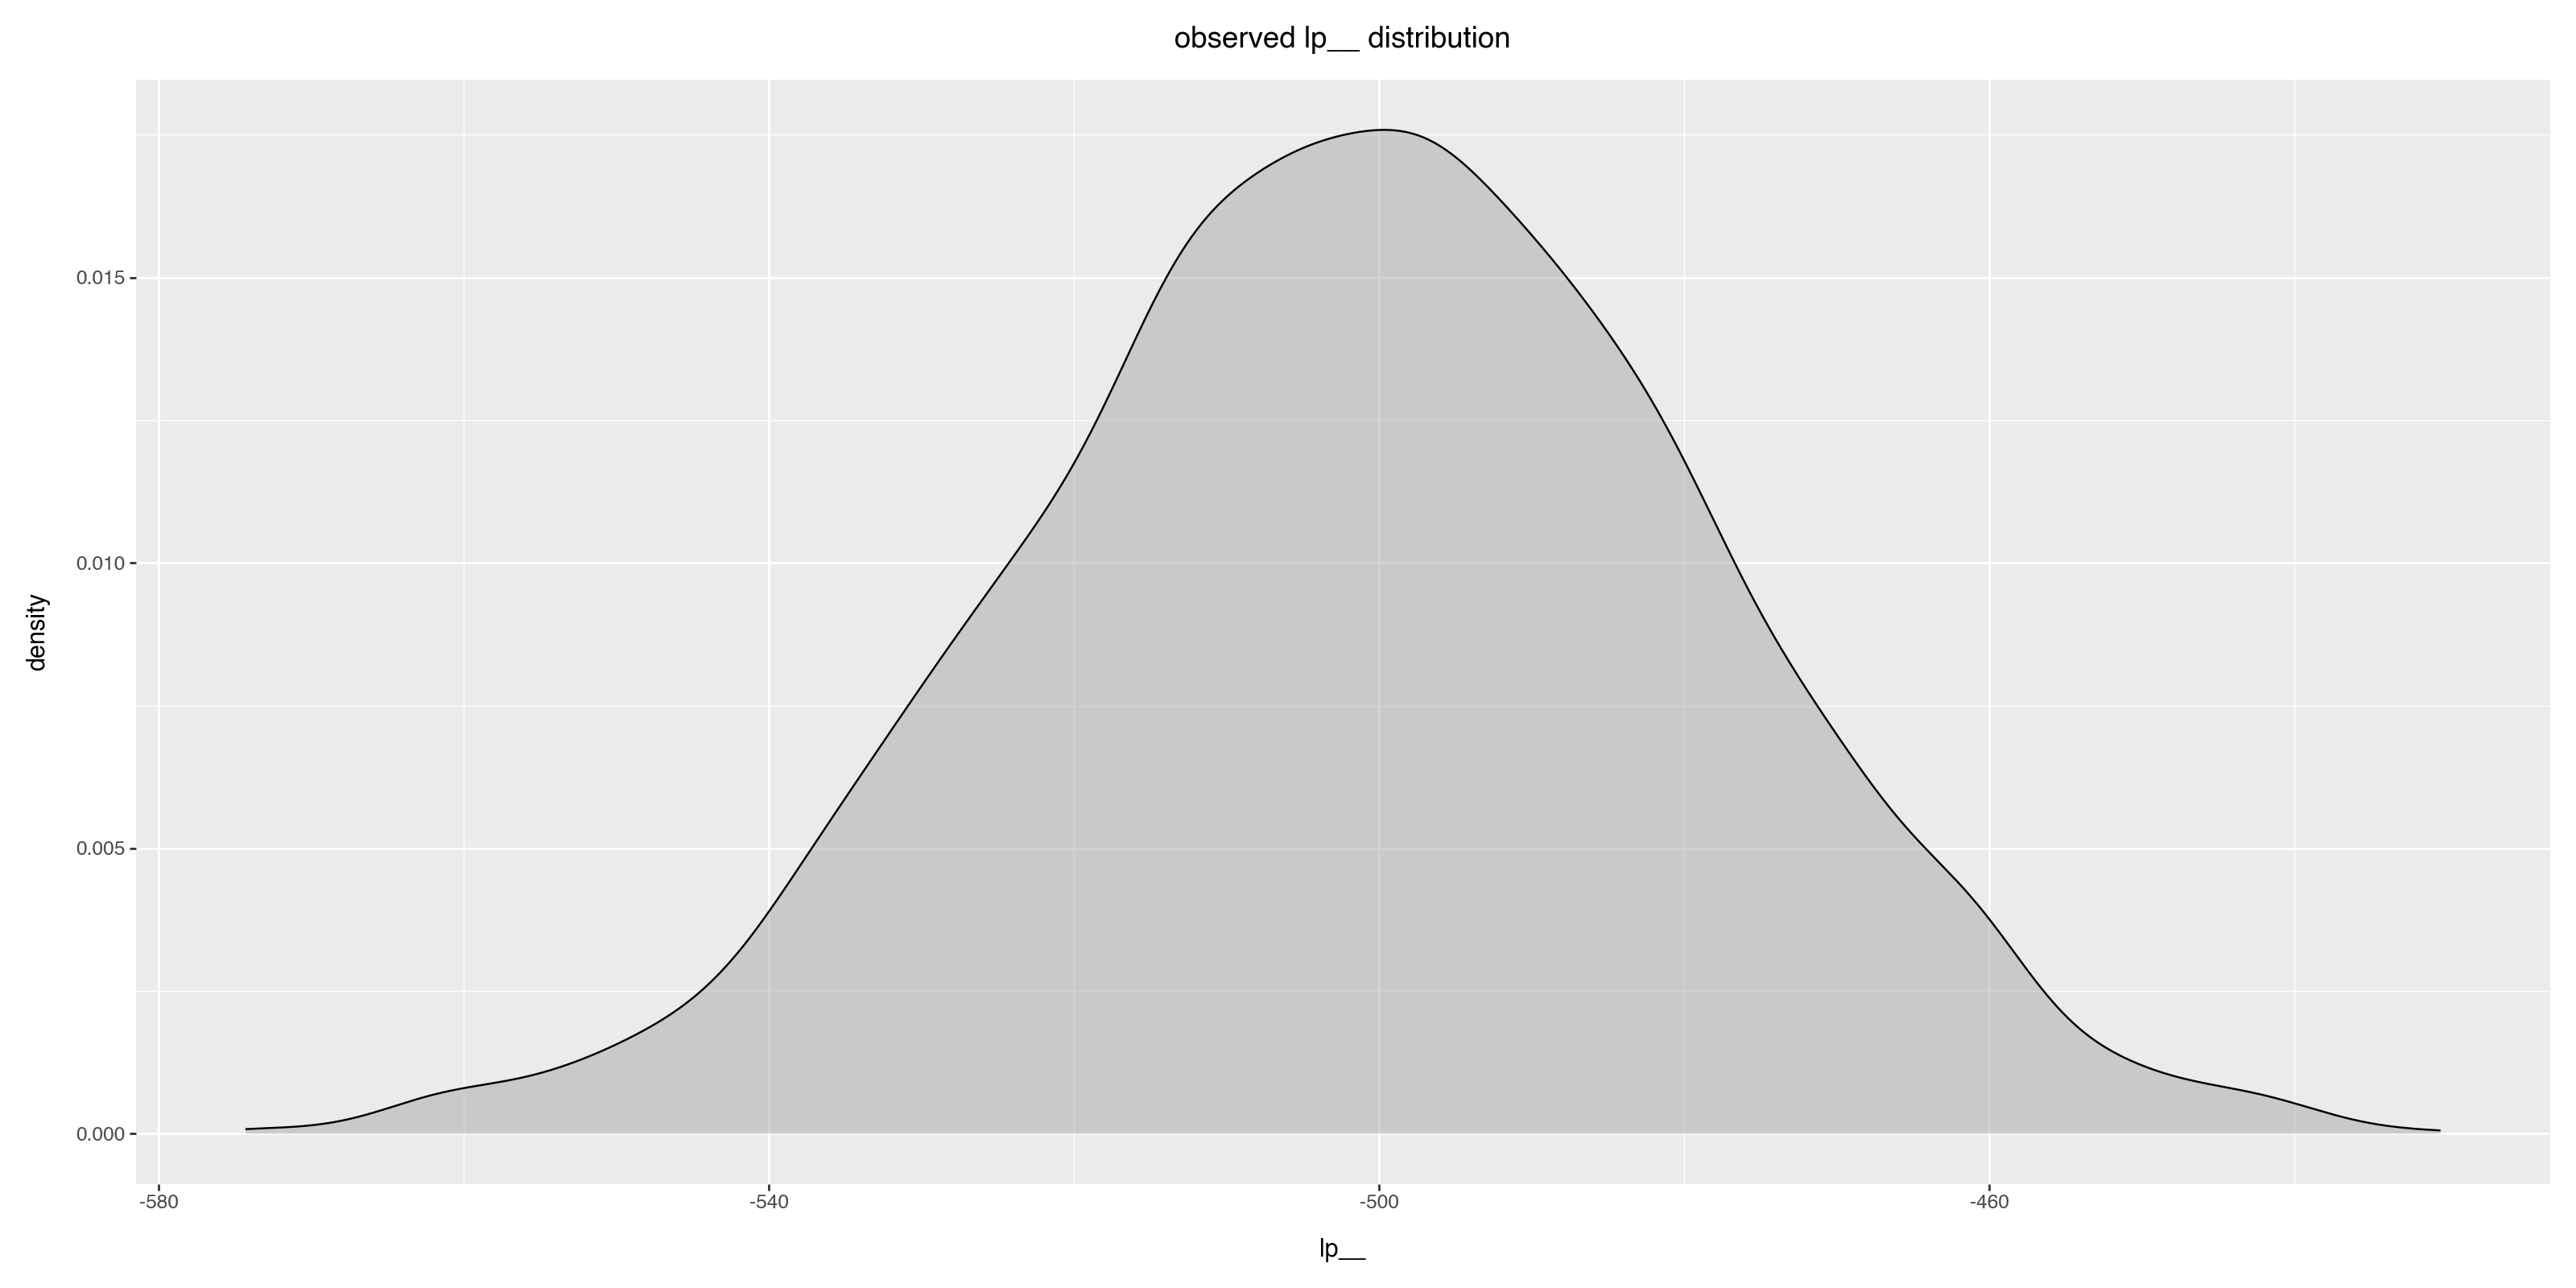

In [8]:
(
    ggplot(
        data=res,
        mapping=aes(x='lp__')
    )
    + geom_density(fill='darkgrey', alpha=0.5)
    + ggtitle("observed lp__ distribution")
)

In [9]:
c = res['c']
log_density = -(c**2)/2 - np.log(2 * np.pi)/2
sum_sq = np.zeros(res.shape[0], dtype=float)
for i in range(1, N+1):
    x = res[f'x[{i}]']
    log_density += -((x - c)**2)/2 - np.log(2 * np.pi)/2 
    sum_sq += (x - c)**2
res['log_density'] = log_density
res['sum_sq'] = sum_sq

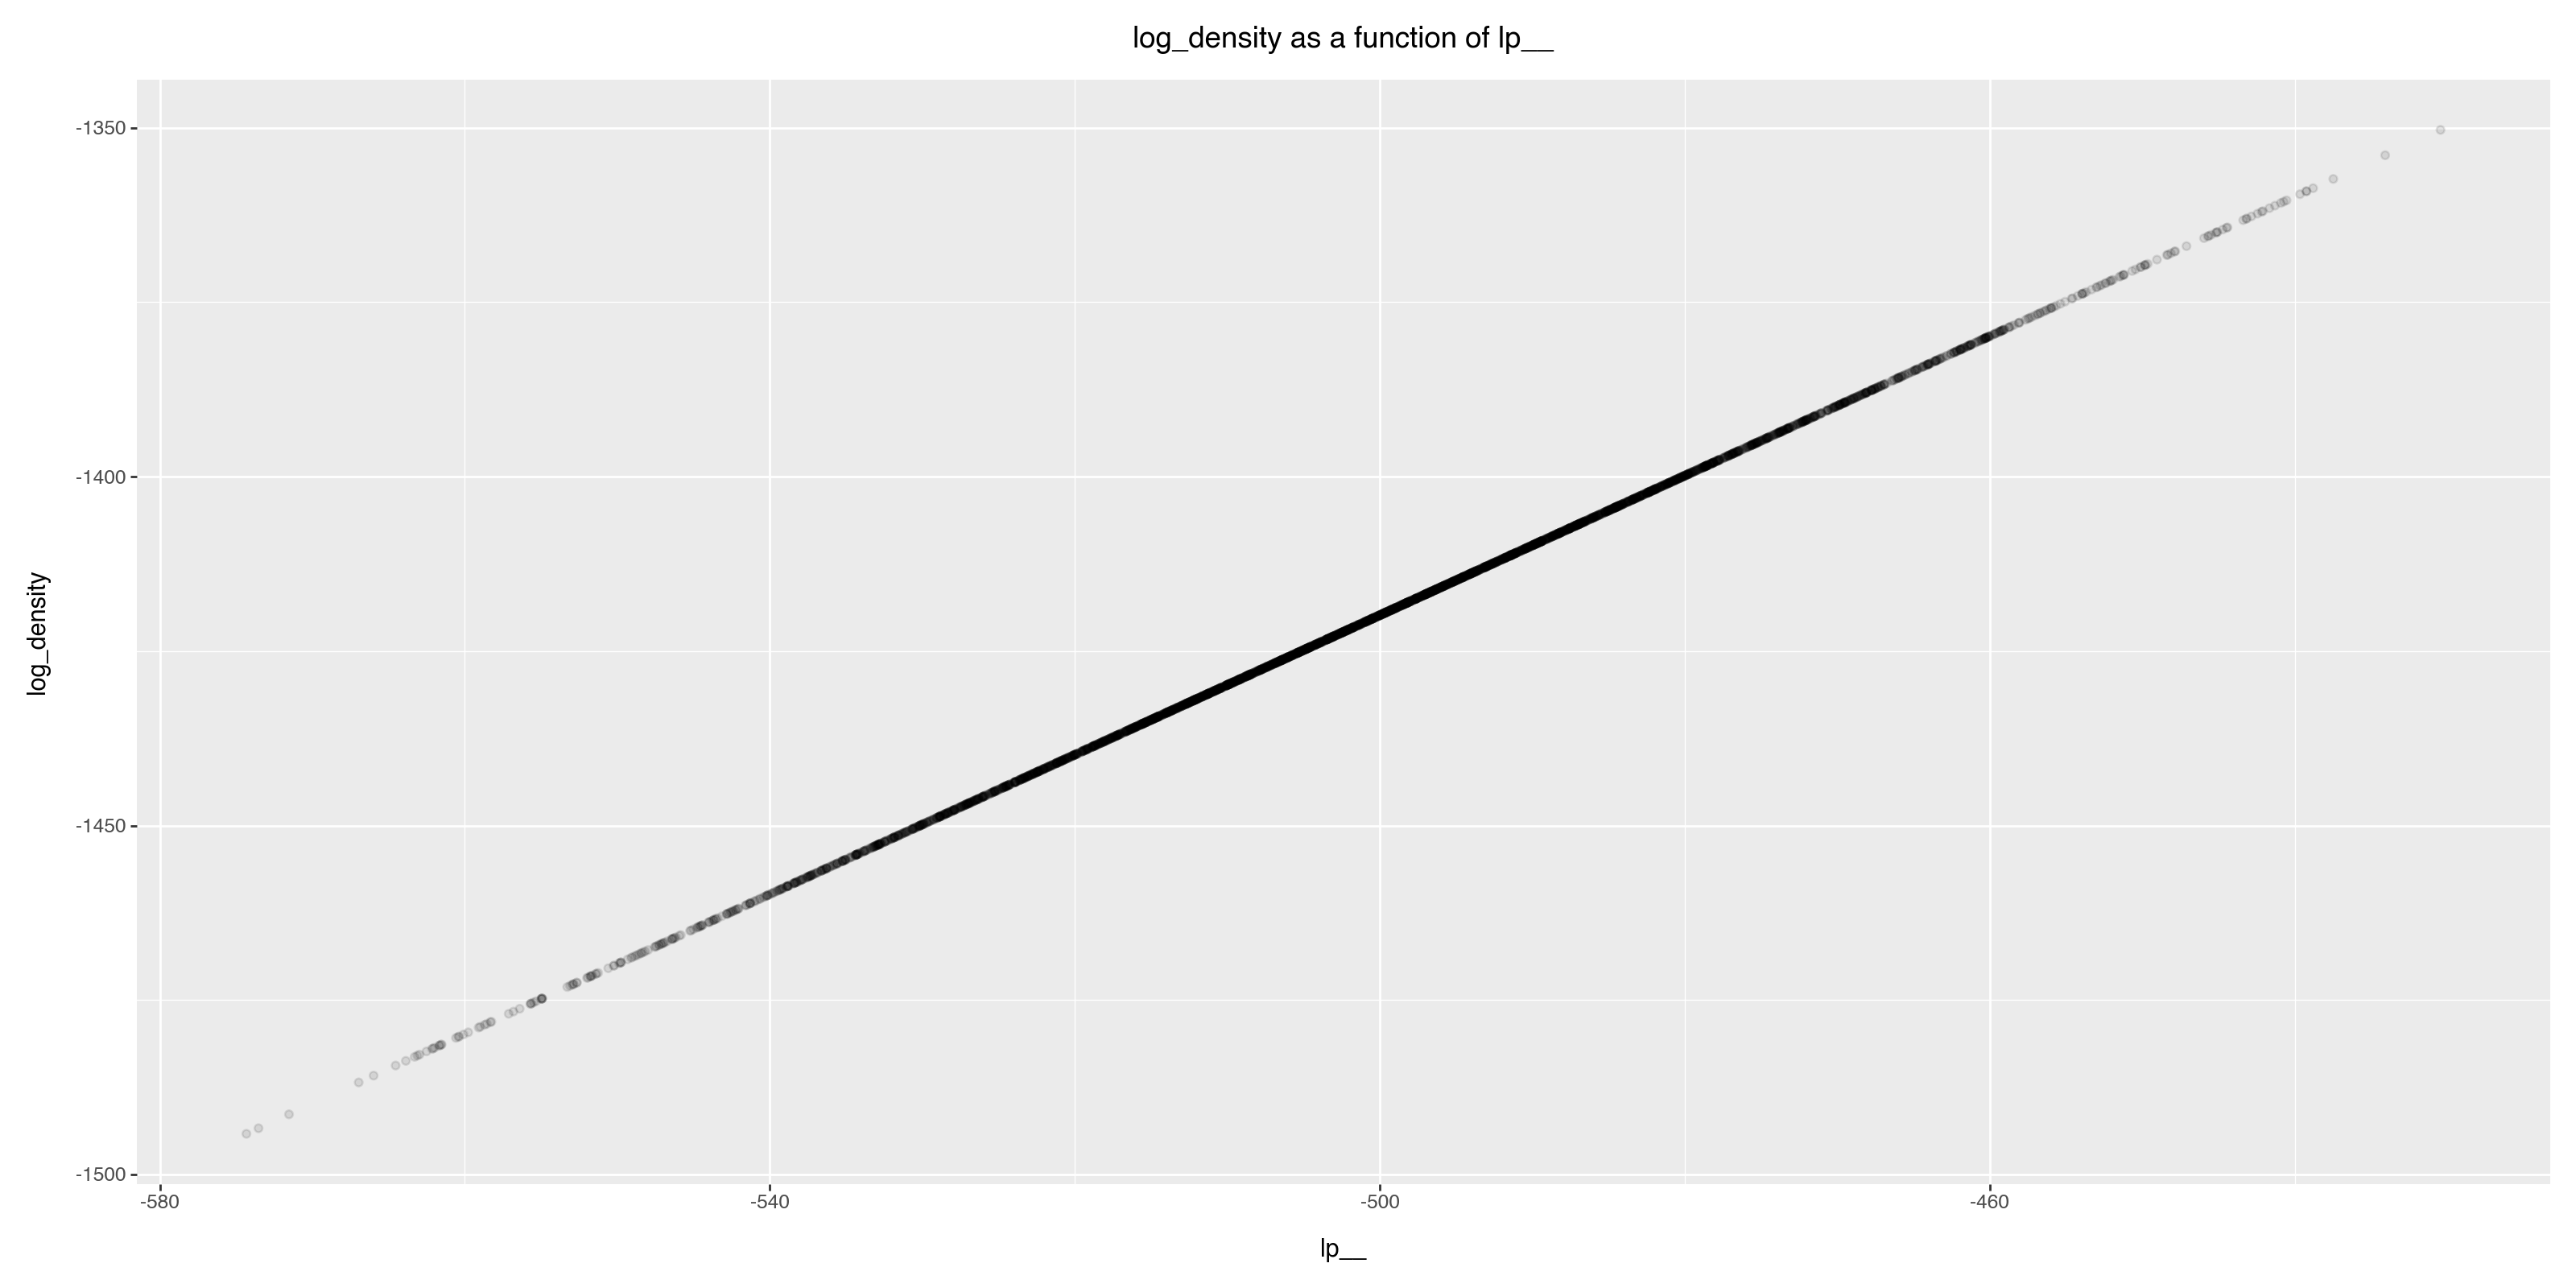

In [10]:
(
    ggplot(
        data=res,
        mapping=aes(x='lp__', y='log_density')
    )
    + geom_point(alpha=0.1)
    + ggtitle("log_density as a function of lp__")
)

In [11]:
log_density_model = LinearRegression()
log_density_model.fit(res[['lp__']], res['log_density'])
(log_density_model.coef_, log_density_model.intercept_)

(array([1.0000001]), -919.857434193801)

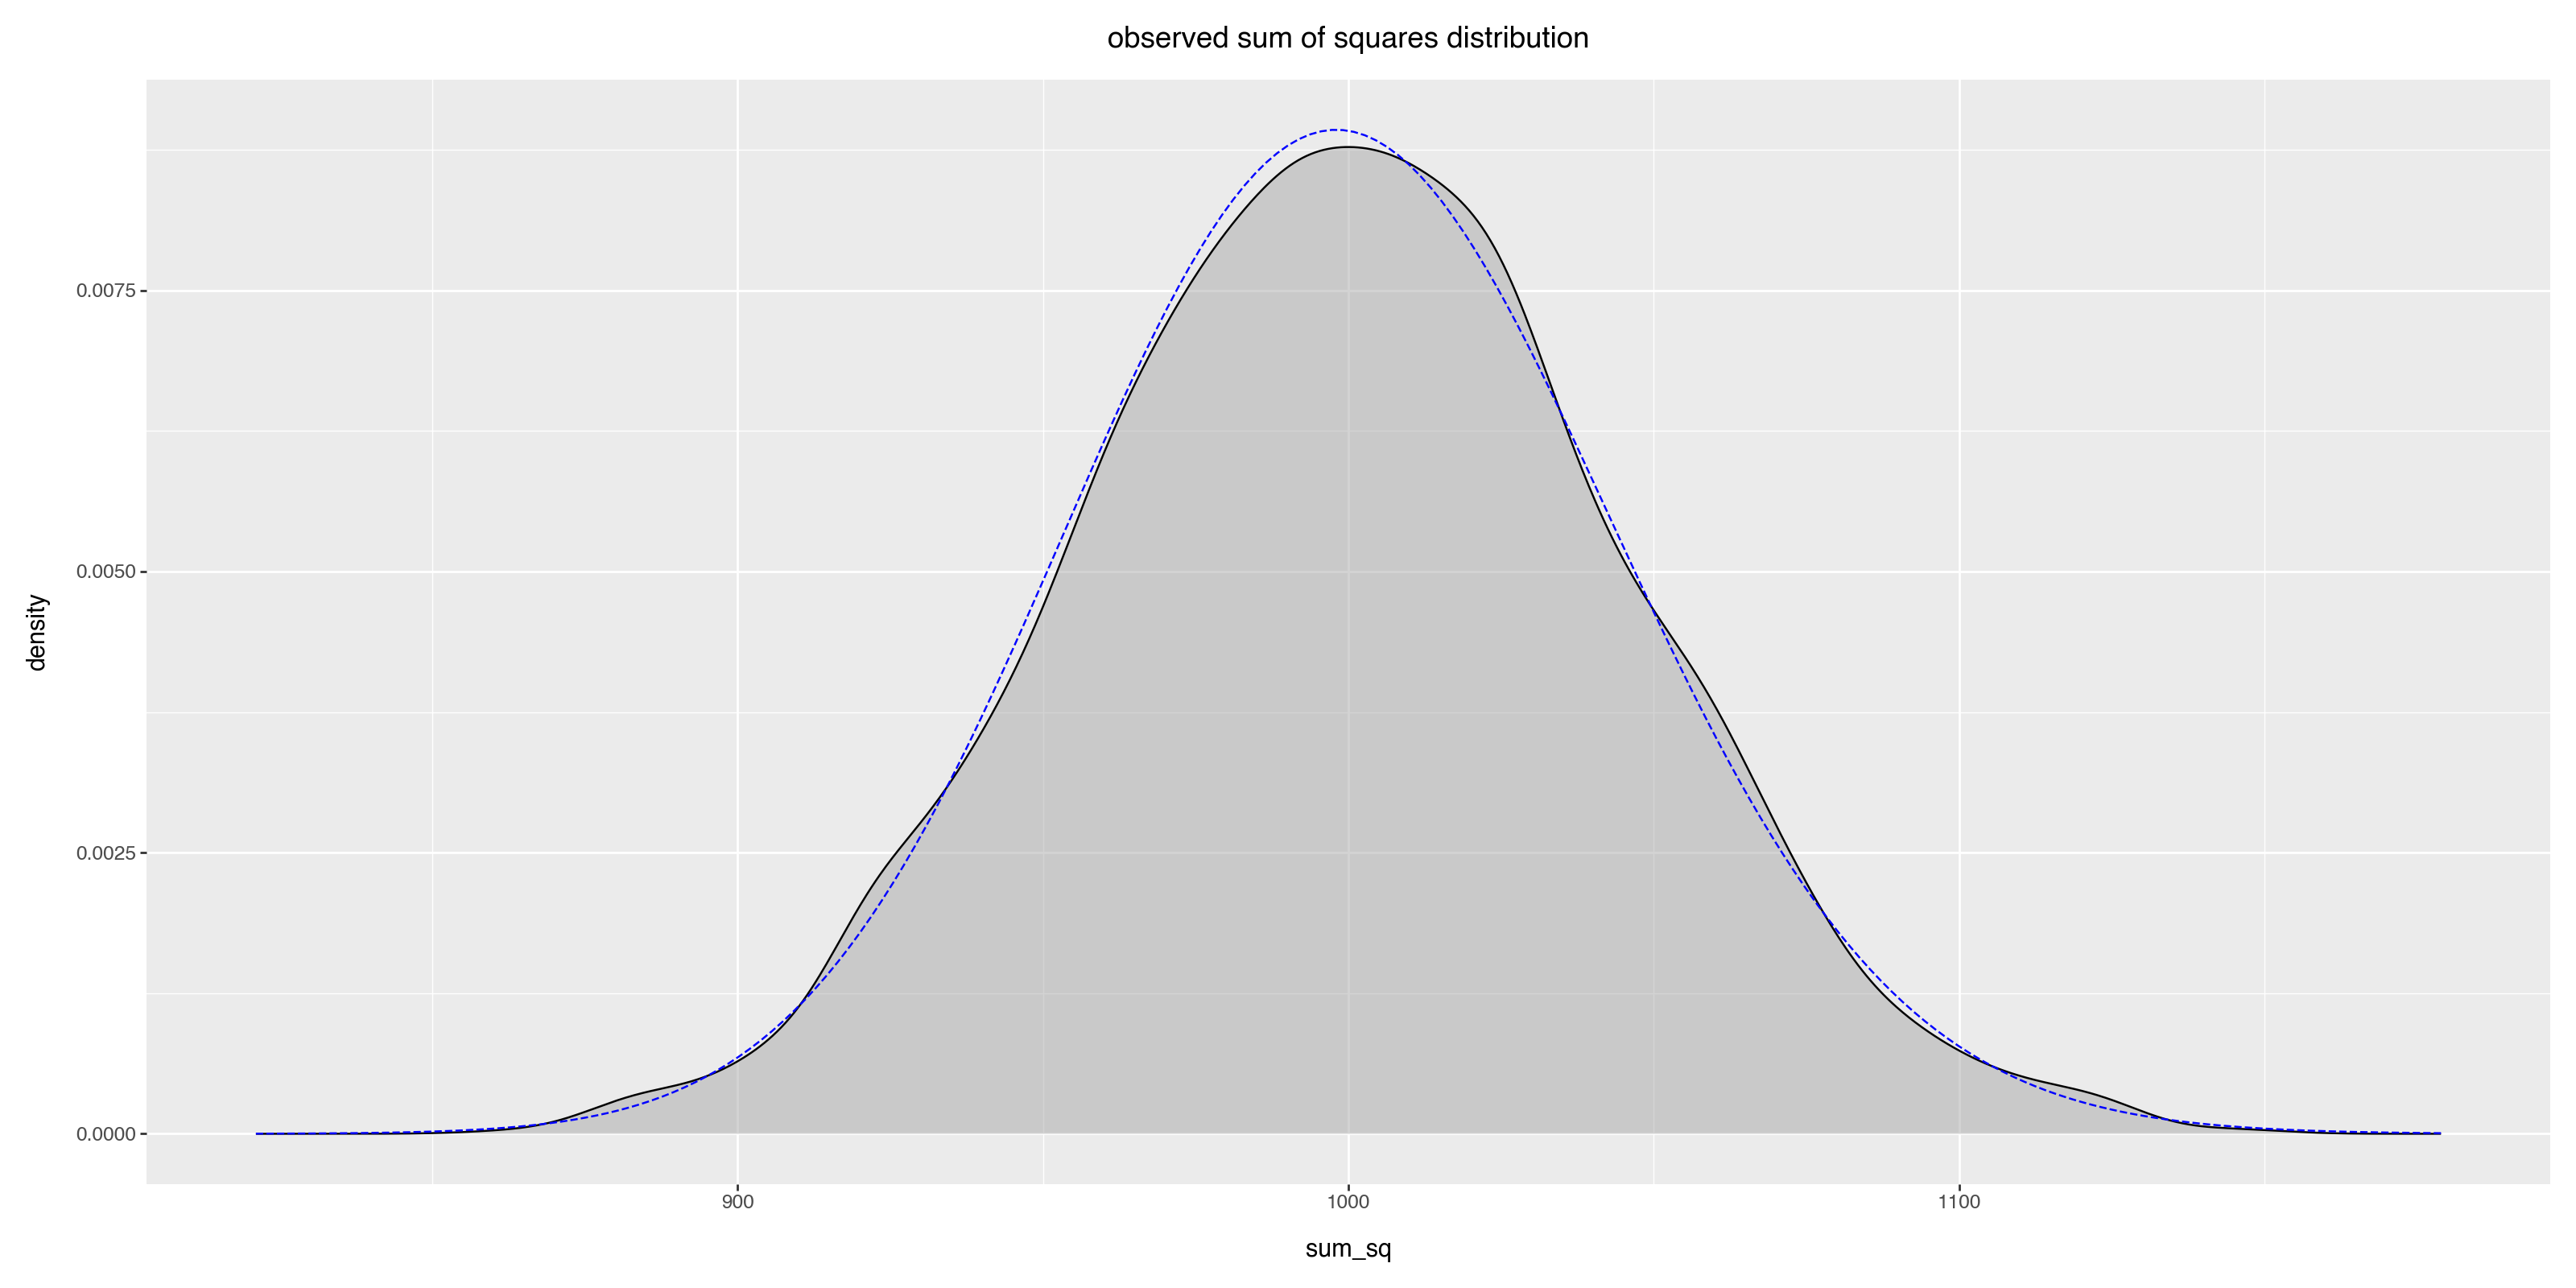

In [12]:
density = pd.DataFrame({
    'sum_sq': np.linspace(
        start=min(N - 4 * np.sqrt(2 * N), np.min(res['sum_sq'])), 
        stop=max(N + 4 * np.sqrt(2 * N), np.max(res['sum_sq'])), 
        num=200),
})
density['pdf'] = chi2.pdf(density['sum_sq'], df=N)
(
    ggplot()
    + geom_density(
        data=res,
        mapping=aes(x='sum_sq'),
        fill='darkgrey', 
        alpha=0.5)
    + geom_line(
        data=density,
        mapping=aes(x='sum_sq', y='pdf'), 
        color='blue', 
        linetype='dashed',
    )
    + ggtitle("observed sum of squares distribution")
)